In [2]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile



import numpy as np
from tensorflow.keras.preprocessing import image
from IPython.display import display

In [3]:
# Download the dataset from a working source
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2025-08-19 15:09:01--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:3c00:c8c::317f, 2600:1409:3c00:c80::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   260MB/s    in 3.0s    

2025-08-19 15:09:04 (260 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [4]:
# verificando o a quantidade de gatos e cachorros
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [14]:
# Note that this may take some time.
history = model.fit(train_generator, epochs=50, steps_per_epoch=25,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - acc: 0.7893 - loss: 0.4456 - val_acc: 0.7480 - val_loss: 0.5066
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - acc: 0.7974 - loss: 0.4356 - val_acc: 0.7740 - val_loss: 0.4554
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - acc: 0.8108 - loss: 0.4044 - val_acc: 0.7700 - val_loss: 0.4601
Epoch 4/50
15/25 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - acc: 0.8139 - loss: 0.4162

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - acc: 0.8125 - loss: 0.4184 - val_acc: 0.7833 - val_loss: 0.4640
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 8s/step - acc: 0.8033 - loss: 0.4155 - val_acc: 0.7100 - val_loss: 0.5603
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - acc: 0.7979 - loss: 0.4223 - val_acc: 0.7947 - val_loss: 0.4341
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - acc: 0.8070 - loss: 0.4198 - val_acc: 0.7840 - val_loss: 0.4371
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - acc: 0.8182 - loss: 0.4011 - val_acc: 0.8100 - val_loss: 0.4154
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 7s/step - acc: 0.8097 - loss: 0.4029 - val_acc: 0.7920 - val_loss: 0.4334
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - acc: 0.8181 - loss: 0.3866 - val_acc: 0.8080 - val_loss: 0.4291
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - acc: 0.8226 - loss: 0.3791 - val_acc: 0.7973 - val_loss: 0.4509
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - acc: 0.8385 - loss: 

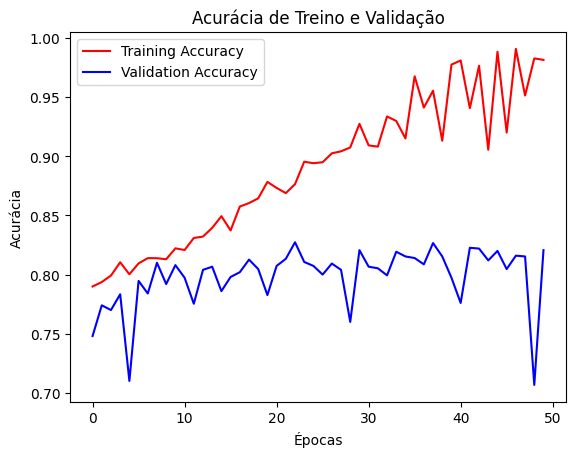

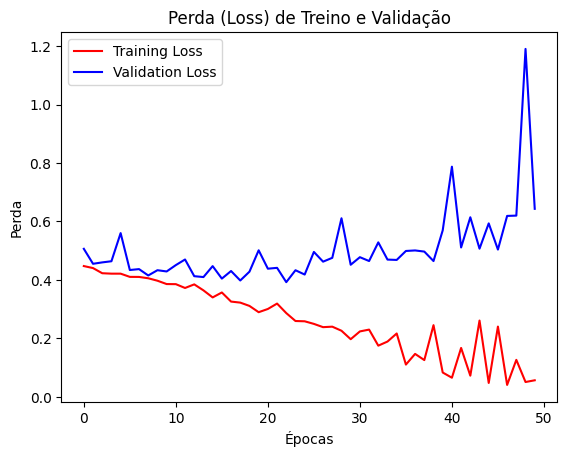

In [15]:
%matplotlib inline

import matplotlib.image as plt
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc))

#-----------------------------------------------------------
# Recupera os resultados do treinamento do objeto 'history'
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Gera os números para o eixo X (0, 1, 2, ..., n-1)

#-----------------------------------------------------------
# Gráfico 1: Acurácia de Treino e Validação
#-----------------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.figure()

#-----------------------------------------------------------
# Gráfico 2: Perda (Loss) de Treino e Validação
#-----------------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Perda (Loss) de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Pega um lote de imagens do gerador de validação
# A cada vez que você executar esta célula, um novo lote aleatório será pego
x_val_batch, y_val_batch = next(validation_generator)

# 2. Faz as previsões com o modelo treinado
predictions = model.predict(x_val_batch)

# 3. Mapeia os índices para os nomes das classes (geralmente {'cats': 0, 'dogs': 1})
# É uma boa prática verificar isso, caso a ordem mude
label_map = {v: k for k, v in validation_generator.class_indices.items()}

# 4. Configura e exibe as imagens com os resultados
plt.figure(figsize=(15, 15))
for i in range(min(15, len(x_val_batch))):  # Mostra as primeiras 15 imagens do lote
    plt.subplot(3, 5, i + 1)

    # O gerador já reescalou as imagens para [0,1], então o imshow funciona bem
    plt.imshow(x_val_batch[i])
    plt.axis('off')

    # Probabilidade prevista (saída da sigmoid)
    predicted_prob = predictions[i][0]

    # Rótulo real (0 ou 1)
    true_label_index = int(y_val_batch[i])
    true_label_name = label_map[true_label_index].capitalize()

    # Converte a probabilidade em uma classe prevista
    if predicted_prob > 0.5:
        predicted_label_name = label_map[1].capitalize()
    else:
        predicted_label_name = label_map[0].capitalize()

    # Define a cor do título: verde para acerto, vermelho para erro
    title_color = 'green' if predicted_label_name == true_label_name else 'red'

    # Monta o título da imagem
    plt.title(f"Previsto: {predicted_label_name} ({predicted_prob:.2f})\nReal: {true_label_name}", color=title_color)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

* Teste com (pets da Família)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[0.34433013]
2.jpg é um gato


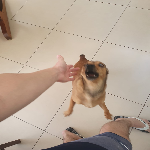

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.1855444]
4.jpg é um gato


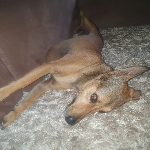

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.985557]
6.jpg é um cachorro


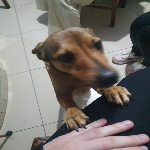

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.02923581]
7.jpg é um gato


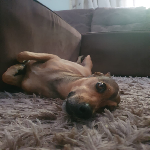

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[0.90698576]
1.jpg é um cachorro


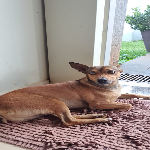

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[2.2843785e-06]
5.jpg é um gato


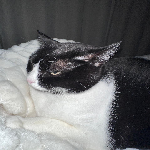

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[0.00835407]
3.jpg é um gato


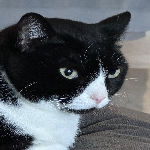

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[0.9999603]
8.jpg é um cachorro


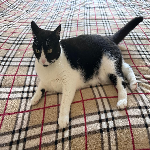

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[0.9813145]
10.jpg é um cachorro


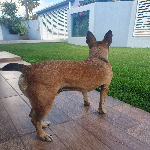

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[4.594104e-09]
12.jpg é um gato


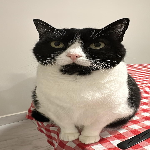

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[0.09278398]
13.jpg é um gato


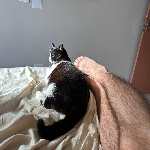

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[0.8166965]
9.jpg é um cachorro


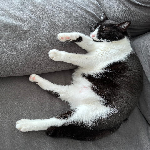

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[0.937408]
11.jpg é um cachorro


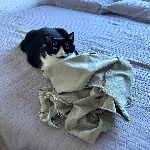

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[0.00027383]
14.jpg é um gato


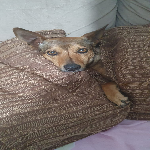

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[0.00135818]
15.jpg é um gato


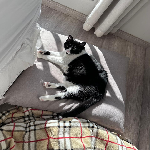

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[2.5324269e-05]
16.jpg é um gato


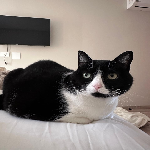

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[0.93661076]
17.jpg é um cachorro


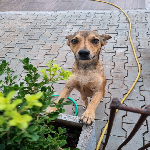

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
[0.8731226]
18.jpg é um cachorro


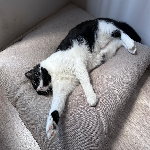

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
[0.01998685]
19.jpg é um gato


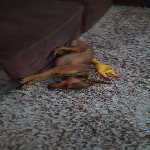

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
[0.03326441]
20.jpg é um gato


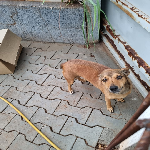

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[0.15769912]
21.jpg é um gato


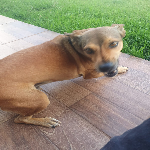

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[0.8452268]
22.jpg é um cachorro


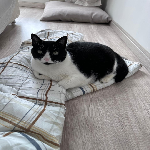

------------------------------


In [18]:


# Caminho da pasta
folder_path = '/content/drive/MyDrive/Colab Notebooks/Projetos_Machine_Learning_DIO/petsFamilia'

# 2. Percorrer cada item da pasta
for fn in os.listdir(folder_path):
    # Constrói o caminho completo para a imagem
    path = os.path.join(folder_path, fn)

    # Verifica se é um arquivo de imagem
    if not os.path.isfile(path) or not fn.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # 3. Carregar e pré-processar a imagem
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0 # Normalizar a imagem

    # 4. Fazer a predição
    classes = model.predict(np.vstack([x]), batch_size=10)
    print(classes[0])

    # 5. Imprimir o resultado
    if classes[0] > 0.5:
        print(fn + " é um cachorro")
    else:
        print(fn + " é um gato")

    # Exibir a imagem
    display(img)
    print("-" * 30) # Apenas para separar os resultados